# Retrieval results

In [49]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from netCDF4 import Dataset
import glob
import matplotlib.pyplot as plt
import numpy as np
from joint_flight.results import get_results, plot_results

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
shapes = ["6-BulletRosette",
          "8-ColumnAggregate",
          "LargeColumnAggregate",
          "LargePlateAggregate",
          "EvansSnowAggregate"]
results_b984 = get_results("b984")
results_c159 = get_results("c159")
results_c161 = get_results("c161")

In [51]:
results_c161["LargePlateAggregate"]["y_cloud_sat"].shape

(422, 45)

## Residuals

/home/simonpf/src/joint_flight/joint_flight/__init__.py:2170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/home/simonpf/src/joint_flight/joint_flight/__init__.py:2170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/home/simonpf/src/joint_flight/joint_flight/__init__.py:2170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


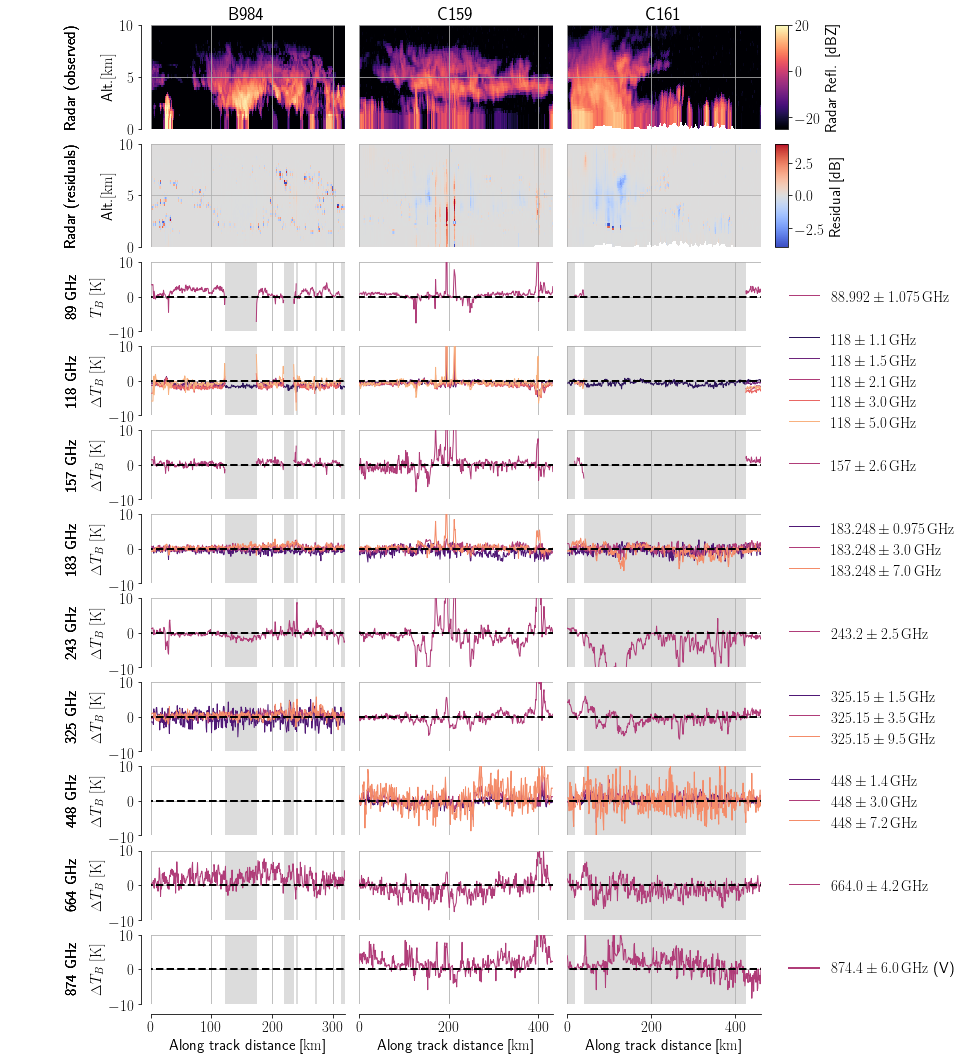

In [53]:
from matplotlib.gridspec import GridSpec
from joint_flight import plot_residuals
from joint_flight.data.b984 import RADAR as radar_b984
from joint_flight.data.c159 import RADAR as radar_c159
from joint_flight.data.c161 import RADAR as radar_c161
from joint_flight.data.b984 import ISMAR as ismar_b984
from joint_flight.data.c159 import ISMAR as ismar_c159
from joint_flight.data.c161 import ISMAR as ismar_c161
from joint_flight.data.b984 import SURFACE_MASK as surface_mask_b984
from joint_flight.data.c159 import SURFACE_MASK as surface_mask_c159
from joint_flight.data.c161 import SURFACE_MASK as surface_mask_c161
fig = plt.figure(figsize=(14, 18))
gs = GridSpec(11, 5,
              width_ratios=[1.0, 1.5, 1.5, 1.5, 0.1],
              height_ratios=[0.75, 0.75, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
             wspace=0.10)


ismar_b984.brightness_temperatures.data[:, [14, 15, 16]] = np.nan
ismar_b984.brightness_temperatures.data[:, -1] = np.nan
ismar_c159.brightness_temperatures.data[:, [7, 9]] = np.nan
ismar_c161.brightness_temperatures.data[:, [7, 9]] = np.nan

names_axs = [plt.subplot(gs[i, 0]) for i in range(11)]
legend_axs = [plt.subplot(gs[i, -1]) for i in range(11)]
axs_b984 = [plt.subplot(gs[i, 1]) for i in range(11)]
axs_c159 = [plt.subplot(gs[i, 2]) for i in range(11)]
axs_c161 = [plt.subplot(gs[i, 3]) for i in range(11)]

plot_residuals(radar_b984, results_b984["LargePlateAggregate"], "b984", surface_mask_b984, axs_b984, legend_axs, names_axs)
plot_residuals(radar_c159, results_c159["LargePlateAggregate"], "cxxx", surface_mask_c159, axs_c159, legend_axs, names_axs, y_axis=False)
plot_residuals(radar_c161, results_c161["LargePlateAggregate"], "cxxx", surface_mask_c161, axs_c161, legend_axs, names_axs, y_axis=False)

axs_b984[0].set_title("B984")
axs_c159[0].set_title("C159")
axs_c161[0].set_title("C161")

plt.show()

fig.savefig("../plots/retrieval_residuals.png", dpi=300, bbox_inches="tight")


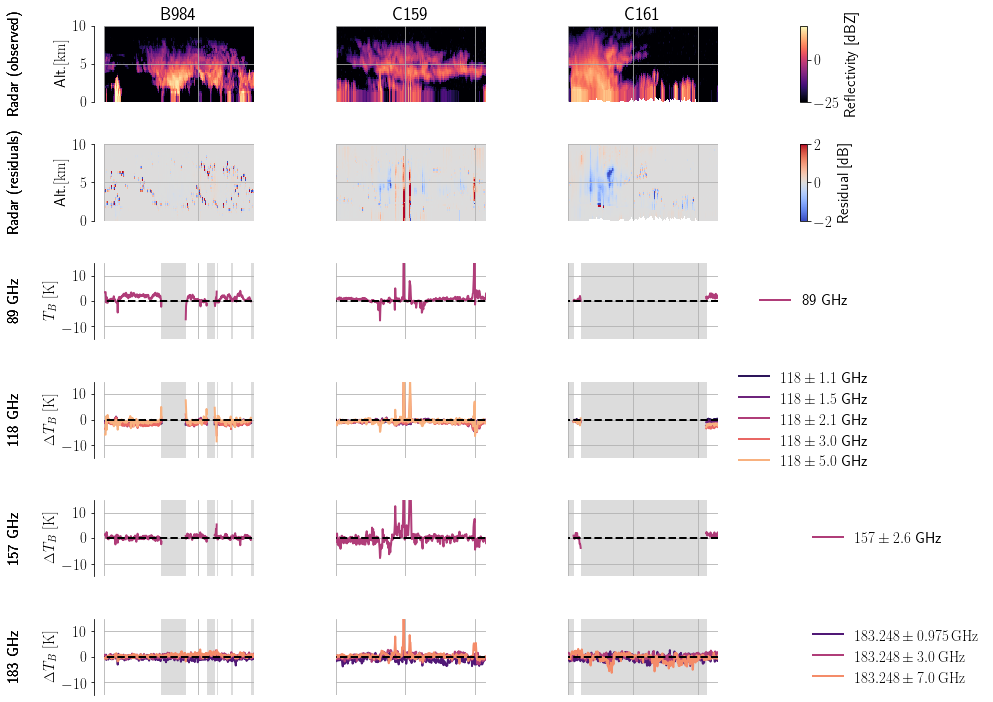

In [54]:
from matplotlib.gridspec import GridSpec
from joint_flight import plot_residuals_lf
from joint_flight.data.b984 import RADAR as radar_b984
from joint_flight.data.c159 import RADAR as radar_c159
from joint_flight.data.c161 import RADAR as radar_c161
from joint_flight.data.b984 import ISMAR as ismar_b984
from joint_flight.data.c159 import ISMAR as ismar_c159
from joint_flight.data.c161 import ISMAR as ismar_c161
from joint_flight.data.b984 import SURFACE_MASK as surface_mask_b984
from joint_flight.data.c159 import SURFACE_MASK as surface_mask_c159
from joint_flight.data.c161 import SURFACE_MASK as surface_mask_c161
fig = plt.figure(figsize=(14, 10))
gs = GridSpec(6, 5,
              width_ratios=[0.1, 1.0, 1.0, 1.0, 0.05]
             )


ismar_b984.brightness_temperatures.data[:, [14, 15, 16]] = np.nan
ismar_b984.brightness_temperatures.data[:, -1] = np.nan
ismar_c159.brightness_temperatures.data[:, [7, 9]] = np.nan
ismar_c161.brightness_temperatures.data[:, [7, 9]] = np.nan

names_axs = [plt.subplot(gs[i, 0]) for i in range(6)]
legend_axs = [plt.subplot(gs[i, -1]) for i in range(6)]
axs_b984 = [plt.subplot(gs[i, 1]) for i in range(6)]
axs_c159 = [plt.subplot(gs[i, 2]) for i in range(6)]
axs_c161 = [plt.subplot(gs[i, 3]) for i in range(6)]

plot_residuals_lf(radar_b984, results_b984["LargePlateAggregate"], "b984", surface_mask_b984, axs_b984, legend_axs, names_axs)
plot_residuals_lf(radar_c159, results_c159["LargePlateAggregate"], "cxxx", surface_mask_c159, axs_c159, legend_axs, names_axs, y_axis=False)
plot_residuals_lf(radar_c161, results_c161["LargePlateAggregate"], "cxxx", surface_mask_c161, axs_c161, legend_axs, names_axs, y_axis=False)

axs_b984[0].set_title("B984")
axs_c159[0].set_title("C159")
axs_c161[0].set_title("C161")

plt.tight_layout()
plt.show()

fig.savefig("../plots/retrieval_resduals_lf.png", dpi=300)

## Residual distributions

(65,) (470, 65) (470, 65)
8212
(65,) (470, 65) (470, 65)
8212
(65,) (470, 65) (470, 65)
8212
(65,) (470, 65) (470, 65)
8212
(65,) (470, 65) (470, 65)
8212


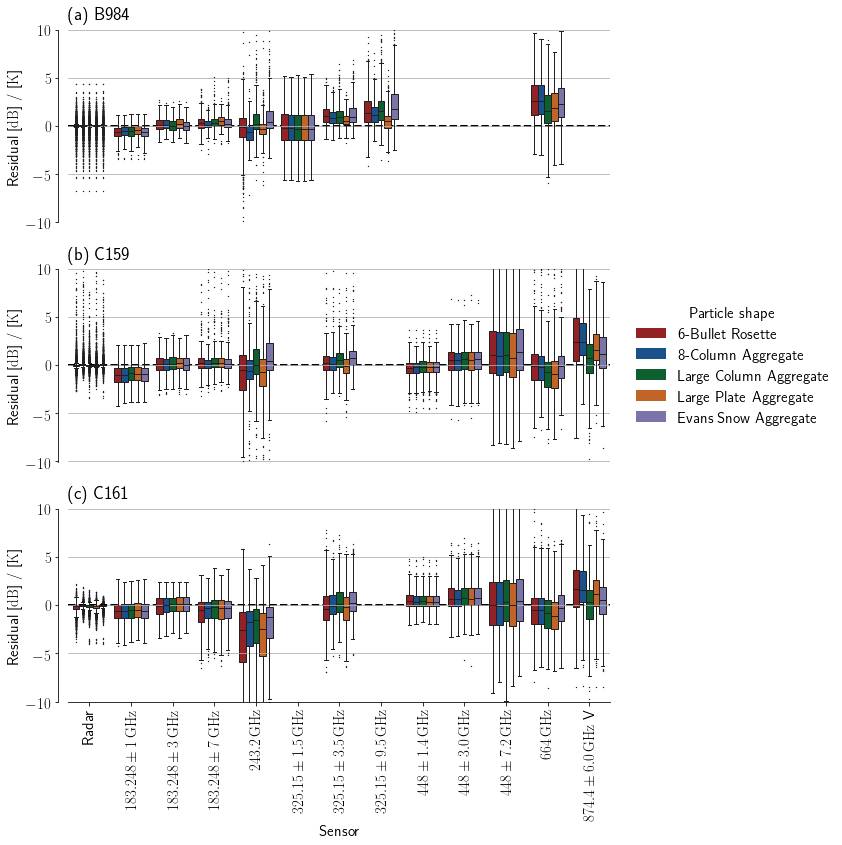

In [57]:
from joint_flight.results import plot_residual_distributions
from matplotlib.patches import Patch, PathPatch
from joint_flight.utils import PARTICLE_NAMES

f = plt.figure(figsize=(12, 12))
gs = GridSpec(3, 2, width_ratios=[1.0, 0.2])

ax_b984 = f.add_subplot(gs[0, 0])
ax_c159 = f.add_subplot(gs[1, 0])
ax_c161 = f.add_subplot(gs[2, 0])

ax_b984.set_title("(a) B984", loc="left", pad=10)
ax_b984.axhline(y=0, ls="--", c="k", zorder=-10)
data = plot_residual_distributions(ax_b984, radar_b984, results_b984, "b984", shapes=shapes)
ax_b984.get_legend().remove()
ax_b984.set_ylim([-10.1, 10])
ax_b984.xaxis.set_visible(False)
ax_b984.spines["bottom"].set_visible(False)
ax_b984.spines["left"].set_position(("outward", 10))
ax_b984.set_ylabel(r"Residual [$\si{\deci \bel}$] / [$\si{\kelvin}$]")

ax_c159.set_title("(b) C159", loc="left", pad=10)
ax_c159.axhline(y=0, ls="--", c="k", zorder=-10)
data = plot_residual_distributions(ax_c159, radar_c159, results_c159, "c159", shapes=shapes)
ax_c159.get_legend().remove()
ax_c159.set_ylim([-10.1, 10])
ax_c159.xaxis.set_visible(False)
ax_c159.spines["bottom"].set_visible(False)
ax_c159.spines["left"].set_position(("outward", 10))
ax_c159.set_ylabel(r"Residual [$\si{\deci \bel}$] / [$\si{\kelvin}$]")

ax_c161.set_title("(c) C161", loc="left", pad=10)
ax_c161.axhline(y=0, ls="--", c="k", zorder=-10)
data = plot_residual_distributions(ax_c161, radar_c161, results_c161, "c161", shapes=shapes)
ax_c161.get_legend().remove()
ax_c161.set_ylim([-10, 10])
ax_c161.spines["left"].set_position(("outward", 10))
ax_c161.set_xlabel(r"Sensor")
ax_c161.set_ylabel(r"Residual [$\si{\deci \bel}$] / [$\si{\kelvin}$]")

for l in ax_c161.xaxis.get_ticklabels():
    l.set_rotation(90)
    
labels = [(c.get_label(), c.get_facecolor()) for c in ax_c161.get_children() if c.get_label() in shapes]
patches = [Patch(facecolor=c, label=l) for l, c in labels]
ax = f.add_subplot(gs[:, -1])
ax.set_axis_off()
labels = [PARTICLE_NAMES[s] for s in shapes]
ax.legend(title="Particle shape", handles=patches, labels=labels, loc="center")

plt.tight_layout()
f.savefig("../plots/residual_distributions.pdf", dpi=300)

/home/simonpf/src/joint_flight/joint_flight/results.py:431: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  m = ax.pcolormesh(
/home/simonpf/src/joint_flight/joint_flight/results.py:431: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  m = ax.pcolormesh(
/home/simonpf/src/joint_flight/joint_flight/results.py:431: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quad

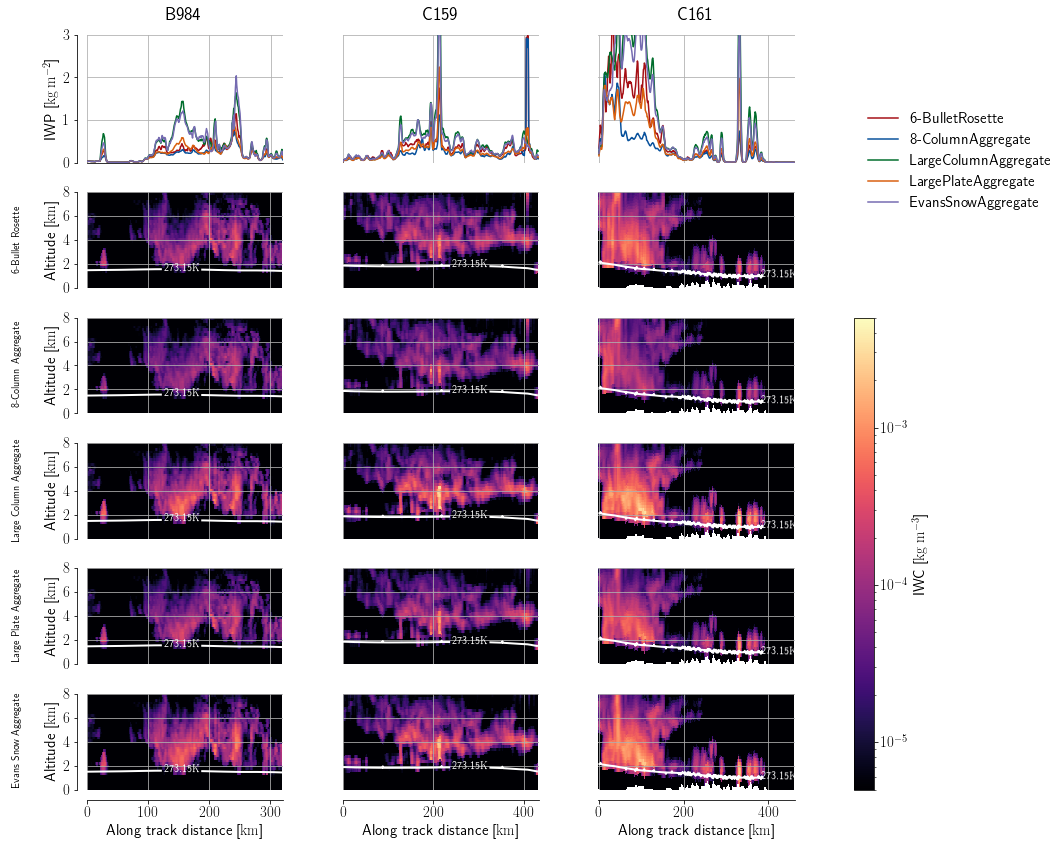

In [58]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from joint_flight.data.b984 import RADAR as radar_b984
from joint_flight.data.c159 import RADAR as radar_c159
from joint_flight.data.c161 import RADAR as radar_c161
from joint_flight.data.b984 import ATMOSPHERE as atmosphere_b984
from joint_flight.data.c159 import ATMOSPHERE as atmosphere_c159
from joint_flight.data.c161 import ATMOSPHERE as atmosphere_c161

m = len(shapes) + 1
gs = GridSpec(m, 5,
              width_ratios=[0.1, 1.0, 1.0, 1.0, 0.1],
              height_ratios=[1.0] + len(shapes) * [0.75])
f = plt.figure(figsize=(15, 12))
names = [f.add_subplot(gs[i, 0]) for i in range(m)]
axs_b984 = [f.add_subplot(gs[i, 1]) for i in range(m)]
axs_c159 = [f.add_subplot(gs[i, 2]) for i in range(m)]
axs_c161 = [f.add_subplot(gs[i, 3]) for i in range(m)]
legends = [f.add_subplot(gs[:2, -1]), f.add_subplot(gs[2:, -1])]

plot_results(radar_b984, results_b984, atmosphere_b984, axs=axs_b984, legends=legends, shapes=shapes, names=names)
plot_results(radar_c159, results_c159, atmosphere_c159, axs=axs_c159, shapes=shapes, y_axis=False)
plot_results(radar_c161, results_c161, atmosphere_c161, axs=axs_c161, shapes=shapes, y_axis=False)
axs_b984[0].set_title("B984", weight="bold", pad=15)
axs_c159[0].set_title("C159", weight="bold", pad=15)
axs_c161[0].set_title("C161", weight="bold", pad=15)

plt.tight_layout()
plt.show()
f.savefig("../plots/ice_water_content.png")

## Comparison to nevzorov data

In [59]:
from joint_flight.data.b984 import NEVZOROV as nevzorov_b984
from joint_flight.data.c159 import NEVZOROV as nevzorov_c159
from joint_flight.results import match_bulk_properties

In [60]:
from joint_flight.results import get_distance_mask, get_domain_mask
results_b984 = {k: results_b984[k] for k in shapes}
results_c159 = {k: results_c159[k] for k in shapes}
#nevzorov_c159["d"] += 40e3
mask_b984 = get_distance_mask(radar_b984, nevzorov_b984)
mask_c159 = get_domain_mask(radar_c159, 50e3, 120e3, nevzorov_c159)
#mask_c159 = get_distance_mask(radar_c159, nevzorov_c159)
matched_b984 = match_bulk_properties(results_b984,
                                     mask_b984,
                                     radar_b984,
                                     nevzorov_b984)
matched_c159 = match_bulk_properties(results_c159,
                                     mask_c159,
                                     radar_c159,
                                     nevzorov_c159)

/home/simonpf/src/joint_flight/joint_flight/results.py:543: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Blues").copy()
  cmap = matplotlib.cm.get_cmap("Blues")
/home/simonpf/src/joint_flight/joint_flight/results.py:543: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Blues").copy()
  cmap = matplotlib.cm.get_cmap("Blues")


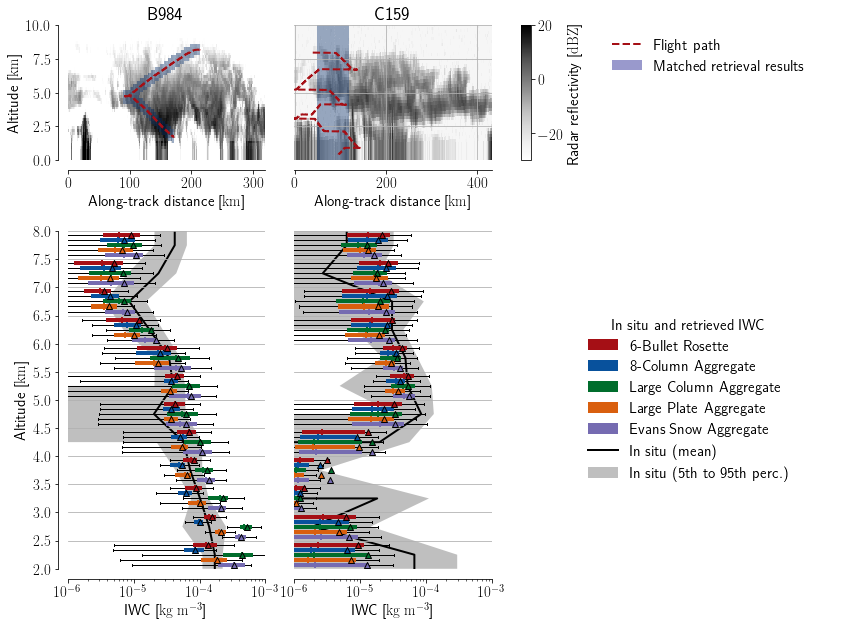

In [61]:
from joint_flight.results import plot_bulk_properties
from matplotlib.gridspec import GridSpec

f = plt.figure(figsize=(15, 10))
gs = GridSpec(2, 5, height_ratios=[0.4, 1.0], width_ratios=[0.1, 1.0, 1.0, 0.05, 1.5], wspace=0.2, hspace=0.3)
axs_b984 = [f.add_subplot(gs[i, 1]) for i in range(2)]
axs_c159 = [f.add_subplot(gs[i, 2]) for i in range(2)]
cbs = [f.add_subplot(gs[i, 3]) for i in range(2)]
legends = [
    f.add_subplot(gs[0, 4]),
    f.add_subplot(gs[1, 3:])
]

plot_bulk_properties(nevzorov_b984,
                     matched_b984,
                     radar_b984,
                     mask_b984,
                     cbs=cbs,
                     shapes=shapes,
                     axs=axs_b984)
plot_bulk_properties(nevzorov_c159,
                     matched_c159,
                     radar_c159,
                     mask_c159,
                     axs=axs_c159,
                     cbs=cbs,
                     shapes=shapes,
                     legends=legends,
                     y_axis=False)
axs_b984[0].set_title("B984", loc="center")
axs_c159[0].set_title("C159", loc="center")
cbs[1].set_axis_off()
f.savefig("../plots/in_situ_iwc.png", dpi=300, bbox_inches="tight")

In [62]:
from joint_flight.results import calculate_iwp
iwp = calculate_iwp(nevzorov_b984, matched_b984, shapes)

In [63]:
s = rf"""\begin{{tabular}}{{l|c}}
Nevzorov & ${iwp["nevzorov"].mean():0.4f} \pm {iwp["nevzorov"].std():0.4f}$ \\
"""

for shape in shapes:
    s += f"{shape} & ${iwp[shape].mean():0.4f} \pm {iwp[shape].std():0.4f}$ \\\\ \n"
s+= "\end{tabular}"

In [64]:
print(s)

\begin{tabular}{l|c}
Nevzorov & $0.3622 \pm 0.0343$ \\
6-BulletRosette & $0.3365 \pm 0.0454$ \\ 
8-ColumnAggregate & $0.2366 \pm 0.0288$ \\ 
LargeColumnAggregate & $0.7837 \pm 0.1361$ \\ 
LargePlateAggregate & $0.3676 \pm 0.0589$ \\ 
EvansSnowAggregate & $0.6831 \pm 0.1043$ \\ 
\end{tabular}


In [73]:
from joint_flight.results import calculate_psds
psd_r_b984 = calculate_psds(results_b984,
                            mask_b984,
                            radar_b984)
psd_r_c159 = calculate_psds(results_c159,
                            mask_c159,
                            radar_c159)

/home/simonpf/src/joint_flight/joint_flight/results.py:896: RuntimeWarning: Mean of empty slice
  indices = np.arange(indices.sum())
/home/simonpf/src/joint_flight/joint_flight/results.py:896: RuntimeWarning: Mean of empty slice
  indices = np.arange(indices.sum())
/home/simonpf/src/joint_flight/joint_flight/results.py:896: RuntimeWarning: Mean of empty slice
  indices = np.arange(indices.sum())
/home/simonpf/src/joint_flight/joint_flight/results.py:896: RuntimeWarning: Mean of empty slice
  indices = np.arange(indices.sum())
/home/simonpf/src/joint_flight/joint_flight/results.py:896: RuntimeWarning: Mean of empty slice
  indices = np.arange(indices.sum())
/home/simonpf/src/joint_flight/joint_flight/results.py:896: RuntimeWarning: Mean of empty slice
  indices = np.arange(indices.sum())
/home/simonpf/src/joint_flight/joint_flight/results.py:896: RuntimeWarning: Mean of empty slice
  indices = np.arange(indices.sum())
/home/simonpf/src/joint_flight/joint_flight/results.py:896: RuntimeWa

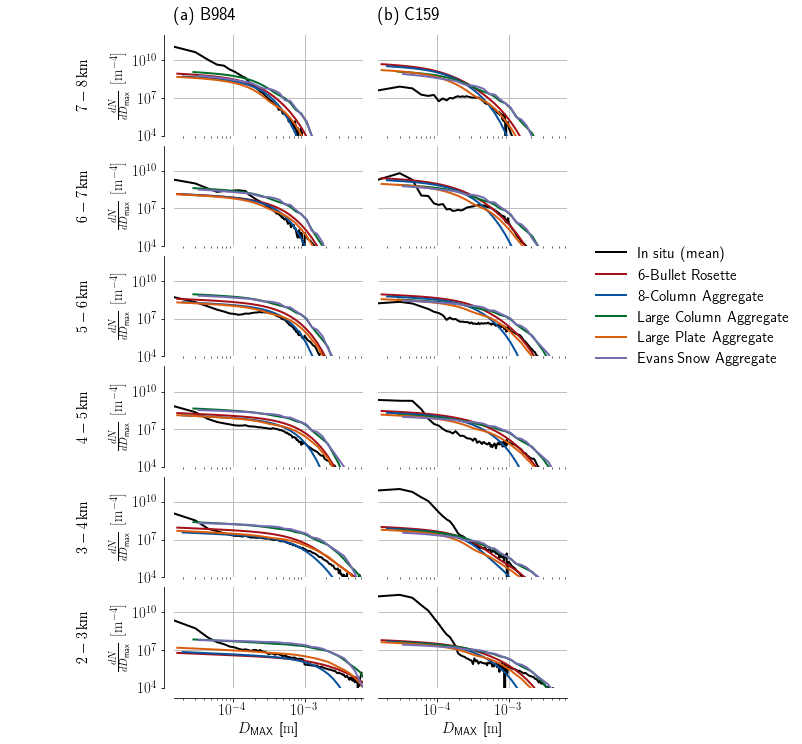

In [74]:
from joint_flight.data.b984 import PSD as psd_b984
from joint_flight.data.c159 import PSD as psd_c159
from joint_flight.results import plot_psds
psd_b984 = psd_b984.resample(time="10s").mean()
psd_c159 = psd_c159.resample(time="10s").mean()
nevzorov_b984 = nevzorov_b984.resample(time="10s").mean()
nevzorov_c159 = nevzorov_c159.resample(time="10s").mean()

fig = plt.figure(figsize=(12, 12))
gs = GridSpec(6, 4, width_ratios=[0.8, 1.0, 1.0, 0.5], wspace=0.1, hspace=0.1)

names_axs = [plt.subplot(gs[i, 0]) for i in range(6)]
legend_axs = [plt.subplot(gs[i, -1]) for i in range(6)]
axs_b984 = [plt.subplot(gs[i, 1]) for i in range(6)]
axs_c159 = [plt.subplot(gs[i, 2], sharey=axs_b984[i]) for i in range(6)]

plot_psds(psd_b984,
          psd_r_b984,
          axs=axs_b984,
          legends=legend_axs,
          shapes=shapes,
          names=names_axs)
plot_psds(psd_c159,
          psd_r_c159,
          axs=axs_c159,
          legends=legend_axs,
          names=names_axs,
          shapes=shapes,
          y_axis=False)
axs_b984[0].set_title("(a) B984", loc="left", pad=15)
axs_c159[0].set_title("(b) C159", loc="left", pad=15)
plt.show()
fig.savefig("../plots/in_situ_psds.pdf", dpi=300, bbox_inches="tight")

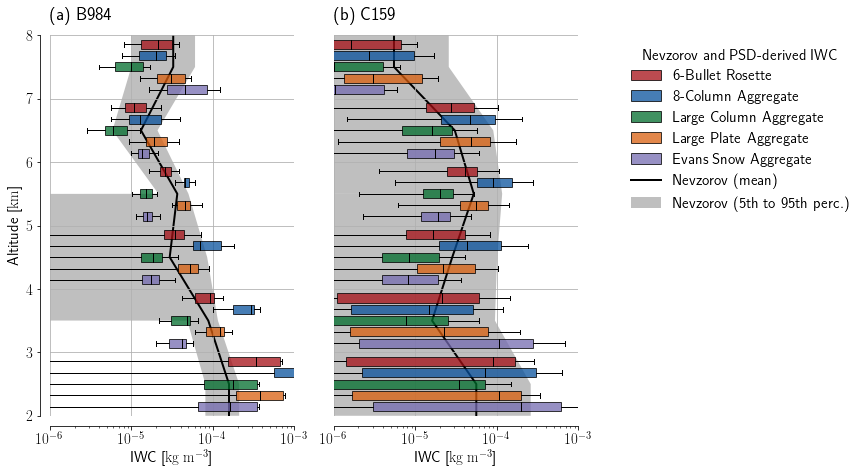

In [75]:
from joint_flight.results import plot_psd_mass
from joint_flight.data.b984 import PSD as psd_b984
from joint_flight.data.c159 import PSD as psd_c159
from joint_flight.results import plot_psds
psd_b984 = psd_b984.resample(time="10s").mean()
psd_c159 = psd_c159.resample(time="10s").mean()
nevzorov_b984 = nevzorov_b984.resample(time="10s").mean()
nevzorov_c159 = nevzorov_c159.resample(time="10s").mean()

fig = plt.figure(figsize=(12, 7))
gs = GridSpec(1, 3, width_ratios=[1.2, 1.2, 0.5])

axs_b984 = [fig.add_subplot(gs[0, 0])]
axs_c159 = [fig.add_subplot(gs[0, 1])]
legend_axs = [fig.add_subplot(gs[0, 2])]

plot_psd_mass(psd_b984,
              nevzorov_b984,
              axs=axs_b984,
              legends=legend_axs,
              shapes=shapes,
              names=names_axs)
plot_psd_mass(psd_c159,
              nevzorov_c159,
              axs=axs_c159,
              legends=legend_axs,
              shapes=shapes,
              names=names_axs,
              y_axis=False)
axs_b984[0].set_title("(a) B984", loc="left", pad=15)
axs_c159[0].set_title("(b) C159", loc="left", pad=15)
#plt.tight_layout()
plt.show()

fig.savefig("../plots/mass_size_relations.png", dpi=200)

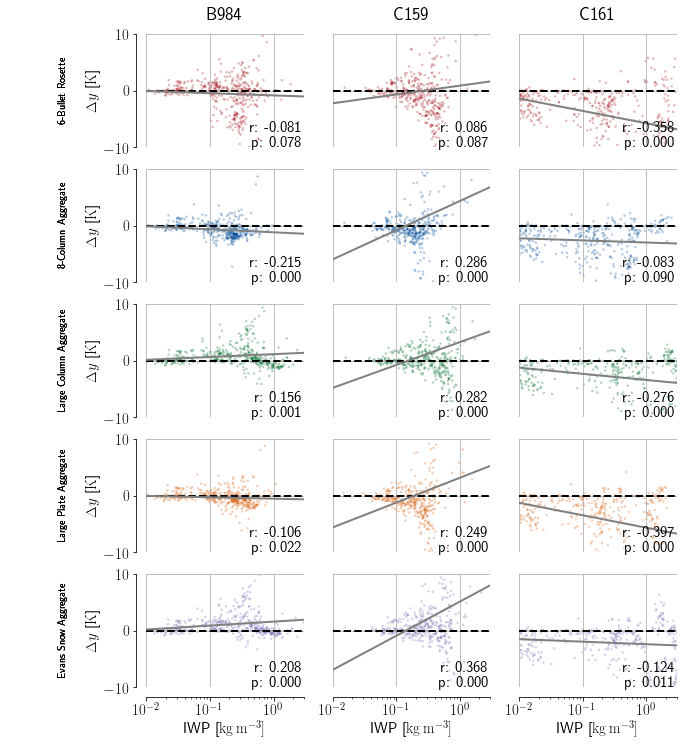

In [85]:
from joint_flight.results import scatter_residuals

f = plt.figure(figsize=(12, 12))
gs = GridSpec(5, 4, width_ratios=[0.7] + 3 * [1.0])

names = [f.add_subplot(gs[i, 0]) for i in range(5)]
axs_b984 = [f.add_subplot(gs[i, 1]) for i in range(5)]
axs_c159 = [f.add_subplot(gs[i, 2]) for i in range(5)]
axs_c161 = [f.add_subplot(gs[i, 3]) for i in range(5)]

scatter_residuals(radar_b984,
                  results_b984,
                  "b984",
                  shapes=shapes,
                  axs=axs_b984,
                  names=names,
                  channel="247")
scatter_residuals(radar_c159,
                  results_c159,
                  "c159",
                  shapes=shapes,
                  axs=axs_c159,
                  y_axis = False,
                  names=names,
                  channel="247")
scatter_residuals(radar_c161,
                  results_c161,
                  "c161",
                  shapes=shapes,
                  axs=axs_c161,
                  y_axis = False,
                  names=names,
                  channel="247")
axs_b984[0].set_title("B984", loc="center", pad=15)
axs_c159[0].set_title("C159", loc="center", pad=15)
axs_c161[0].set_title("C161", loc="center", pad=15)
f.savefig("../plots/residuals_scatter.png", dpi=300, bbox_inches="tight")

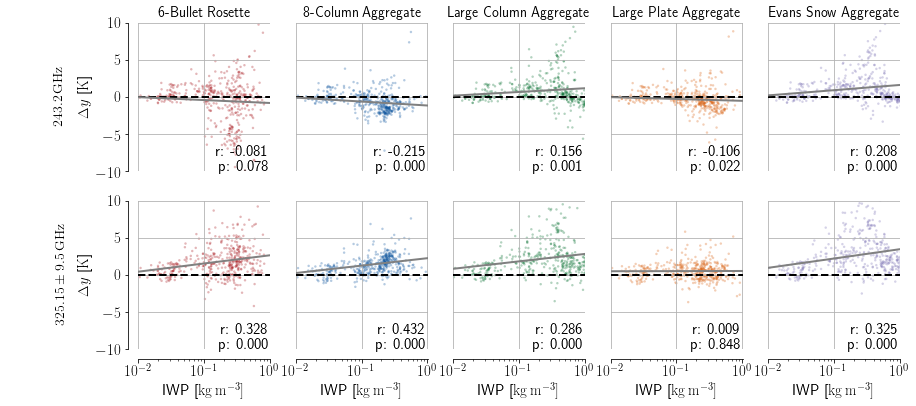

In [91]:
from joint_flight.results import scatter_residuals_b984

f, axs = scatter_residuals_b984(radar_b984,
                                results_b984,
                                shapes=shapes)
f.savefig("../plots/residuals_scatter_b984.png", dpi=300, bbox_inches="tight")

In [79]:
from joint_flight.results import scatter_residuals

f = plt.figure(figsize=(12, 12))
gs = GridSpec(5, 4, width_ratios=[0.7] + 3 * [1.0])

names = [f.add_subplot(gs[i, 0]) for i in range(5)]
axs_b984 = [f.add_subplot(gs[i, 1]) for i in range(5)]
axs_c159 = [f.add_subplot(gs[i, 2]) for i in range(5)]
axs_c161 = [f.add_subplot(gs[i, 3]) for i in range(5)]

scatter_residuals(radar_b984,
                  results_b984,
                  "b984",
                  shapes=shapes,
                  axs=axs_b984,
                  names=names,
                  channel="325")
scatter_residuals(radar_c159,
                  results_c159,
                  "c159",
                  shapes=shapes,
                  axs=axs_c159,
                  y_axis = False,
                  names=names,
                  channel="325")
scatter_residuals(radar_c161,
                  results_c161,
                  "c161",
                  shapes=shapes,
                  axs=axs_c161,
                  y_axis = False,
                  names=names,
                  channel="325")
axs_b984[0].set_title("B984", loc="center", pad=15)
axs_c159[0].set_title("C159", loc="center", pad=15)
axs_c161[0].set_title("C161", loc="center", pad=15)
f.savefig("../plots/residuals_scatter.png", dpi=300, bbox_inches="tight")

ValueError: 
\si{\kelvin}
^
Unknown symbol: \si, found '\'  (at char 0), (line:1, col:1)

ValueError: 
\si{\kelvin}
^
Unknown symbol: \si, found '\'  (at char 0), (line:1, col:1)

<Figure size 864x864 with 20 Axes>

## 